In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import matplotlib.image as pltimg
import graphviz 

############################
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor,VotingClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, KFold, train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
from sklearn.tree._export import plot_tree



C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Windows-10-10.0.18362-SP0
Python 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
NumPy 1.18.1
SciPy 1.4.1
Scikit-Learn 0.22.1


In [6]:
#from google.colab import drive

#drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

In [5]:
# o "../" pega o arquivos que estão um nível acima da pasta que estou
df_Nacional = pd.read_csv('../microdadosEnem_Nacional_Amostragem.csv', sep = ';', encoding='ISO 8859-1')
df_Nacional.columns

Index(['Unnamed: 0', 'NU_INSCRICAO', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006',
       'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015',
       'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025', 'Q026', 'Q027'],
      dtype='object')

In [7]:
df_Nacional = df_Nacional.loc[:, ~df_Nacional.columns.str.contains('^Unnamed')]
#df_Alagoas = df_Alagoas[0:10000]
nota = 'NU_NOTA_REDACAO'
feature_cols = [x for x in df_Nacional.columns if x != nota]
X = df_Nacional[feature_cols]
Y = df_Nacional[nota]



In [8]:
df_Nacional.shape

(64605, 41)

# Variável alvo é a nota de redação dos participantes

In [9]:
# Leitura dos datasets de treino e teste e criação do df de resposta
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0)
#df_resposta = pd.DataFrame()
print(X.shape, Y.shape, X_train.shape, y_train.shape ,X_test.shape, y_test.shape)

(64605, 40) (64605,) (45223, 40) (45223,) (19382, 40) (19382,)


# Pré-processamento

In [10]:
#dataframe que irá receber a resposta dada pelo sistema
df_resposta = pd.DataFrame()

#dataframe que guarda a nota orginal obtida pelo participante
df_resposta['NU_INSCRICAO'] = X_test['NU_INSCRICAO']
df_resposta[nota] = y_test

In [9]:
#df_Alagoas.columns

In [14]:
numeric_features = ['NU_IDADE', 'TP_SEXO','TP_ESTADO_CIVIL', 'TP_COR_RACA','TP_ANO_CONCLUIU', 'TP_ESCOLA',
                    'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',  'Q005']

numeric_transformer = Pipeline(   steps=[ ('scaler', StandardScaler())])

categorical_features = ['Q001', 'Q002', 'Q003', 'Q004','Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011','Q012', 'Q013', 'Q014',
                        'Q015','Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

X_train = X_train[numeric_features + categorical_features]
X_test = X_test[numeric_features + categorical_features]

preprocessing = ColumnTransformer(transformers=[
                                        ('num', numeric_transformer, numeric_features),                                       
                                        ('cat', categorical_transformer, categorical_features),  
])

In [15]:
feature_names= numeric_features + categorical_features
len(feature_names)
print(feature_names)

['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q005', 'Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']


In [12]:
#rint(X_train, X_test)
#https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance

# Aplicando o regressor

## Random Forest

In [16]:
#rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 )
rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 ))
])
rf.fit(X_train, y_train)
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
#y_pred = rf.predict(X_test)



#print(y_pred)

RF train accuracy: 0.878
RF test accuracy: 0.300


## Regressão Linear

In [17]:
lr =  Pipeline([
    ('preprocess', preprocessing),
    ('regressor', LinearRegression())
])
lr.fit(X_train, y_train)

# score = Return the coefficient of determination R^2 of the prediction
print("RN train R²: %0.3f" % lr.score(X_train, y_train))
print("RN test R²: %0.3f" % lr.score(X_test, y_test))

RN train R²: 0.381
RN test R²: 0.365


## Rede neural

In [18]:
rn = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', MLPRegressor(hidden_layer_sizes=(50, 50),tol=1e-2,max_iter=500, random_state=0))
])
rn.fit(X_train, y_train)

# score = Return the coefficient of determination R^2 of the prediction
print("RN train R²: %0.3f" % rn.score(X_train, y_train))
print("RN test R²: %0.3f" % rn.score(X_test, y_test))


C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RN train R²: 0.473
RN test R²: 0.313


# Árvore de decisão

In [19]:
dtree = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
dtree.fit(X_train, y_train)

# # score = Return the coefficient of determination R^2 of the prediction
print("Coefficient of determination R² of the prediction train.: %0.3f" % dtree.score(X_train, y_train))
print("Coefficient of determination R² of the prediction test: %0.3f" % dtree.score(X_test, y_test))
#x = dtree.named_steps['regressor'].feature_importances_


Coefficient of determination R² of the prediction train.: 1.000
Coefficient of determination R² of the prediction test: -0.300


In [20]:
#df_resposta['NU_NOTA_MT_predRF'] = y_pred
df_metricas = pd.DataFrame()
df_resposta.shape

df_features_importance =  pd.DataFrame()


In [15]:
print(df_metricas)
print(df_resposta)
print(df_features_importance)

Empty DataFrame
Columns: []
Index: []
       NU_INSCRICAO  NU_NOTA_REDACAO
59340  180013272216            560.0
10626  180007664987            600.0
18410  180007324620            360.0
16294  180008690383            600.0
59440  180013685090            360.0
...             ...              ...
17858  180007217035            560.0
9917   180008716811            340.0
45121  180011130270            380.0
3741   180007739742            620.0
51183  180011867479            340.0

[19382 rows x 2 columns]
Empty DataFrame
Columns: []
Index: []


In [21]:
def GuardaFeatures(clf, label):
    
    df_features_importance[label] = clf.named_steps['regressor'].feature_importances_
            
    ohe                           = (clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'])
            
    feature_names                 = ohe.get_feature_names(input_features=categorical_features)
            
    df_features_importance['feature_names' + label] =  np.r_[feature_names, numeric_features] 
    

# Aplicando os regressores

In [22]:
import time
scorings=['r2']

clfs = [rf, lr, rn, dtree]
start_time = time.time()
valores=[]
i=0
for clf, label in zip(clfs, ['Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']):
    
        tempro_processamento = time.time()
        
        print( "Processando o modelo: [%s]" % label)
        
       # cv = cross_validate(clf, X_train, y_train, cv=5,  n_jobs=-1, verbose=0, return_train_score=True)        
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        
        y_pred = cross_val_predict(clf, X_test, y_test, n_jobs=-1, verbose=0)     
        
        df_resposta[nota+'_'+ label] = y_pred
        
        df_metricas['Modelo']                    = ['Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']
        
        df_metricas.loc[i,'Max_Error']           = round(max_error(y_test, y_pred), 2)
        df_metricas.loc[i,'MAE']                 = round(mean_absolute_error(y_test, y_pred), 2)         
        df_metricas.loc[i,'R²']                  = round(r2_score(y_test, y_pred), 2)
        df_metricas.loc[i,'MSE']                 = round(mean_squared_error(y_test, y_pred), 2)
        df_metricas.loc[i,'CV scores mean']      = round(cv_scores.mean(), 2)
        df_metricas.loc[i,'CV scores std']       = round(cv_scores.std(), 2)
          
        
      
        if(label == "Random Forest"):
           
            GuardaFeatures(clf, label)
           
        elif(label == "Árvore de decisão"):
            
            GuardaFeatures(clf, label)
            
            
        tempo = (time.time() - tempro_processamento)
        tempoMinutos =  tempo/60  
        df_metricas.loc[i, 'Tempo de processamento min'] = round( tempoMinutos, 2)
        
        print("Tempo de processamento [%s] em minutos: %f  " %( label, round( tempoMinutos, 2) ) )
        print('\n')
        i+=1
       
        #print("Accuracy: %0.2f (+/- %0.2f) [%s]" % ( cv_scores.mean(),  cv_scores.std(), label))
        
       
    
    
elapsed_time = time.time() - start_time

print("tempo de processamento total em minutos:" , (round(elapsed_time/60, 2)))
print('Processamento finalizado')
#print(elapsed_time)

Processando o modelo: [Random Forest]
Tempo de processamento [Random Forest] em minutos: 7.100000  


Processando o modelo: [Regressão Linear]
Tempo de processamento [Regressão Linear] em minutos: 0.230000  


Processando o modelo: [Rede Neural]


C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

Tempo de processamento [Rede Neural] em minutos: 33.040000  


Processando o modelo: [Árvore de decisão]
Tempo de processamento [Árvore de decisão] em minutos: 2.000000  


tempo de processamento total em minutos: 42.38
Processamento finalizado


# Salvando os dataframes com os resultados

In [23]:

df_resposta[[nota+'_Random Forest',  nota+'_Regressão Linear',     nota+'_Rede Neural']]      = df_resposta[[nota+'_Random Forest', nota+'_Regressão Linear', nota+'_Rede Neural' ]].applymap("{0:.1f}".format).astype('float64')



In [24]:
df_metricas


,Modelo,Max_Error,MAE,R²,MSE,CV scores mean,CV scores std,Tempo de processamento min
0,Random Forest,768.00,120.60,0.29,23802.45,0.31,0.01,7.10
1,Regressão Linear,728.93,114.89,0.36,21442.59,0.38,0.01,0.23
2,Rede Neural,690.00,118.41,0.32,22940.10,0.32,0.01,33.04
3,Árvore de decisão,940.00,162.06,-0.31,44051.02,-0.31,0.01,2.00


In [25]:
#Salvar num arquivo csv o dataframe com os dados de Alagoas

df_resposta.to_csv('microdadosRespostaNacional.csv', sep = ';', encoding='ISO 8859-1')
df_features_importance.to_csv('microdadosFeaturesImportancesBR.csv', sep = ';', encoding='ISO 8859-1')
df_metricas.to_csv('microdadosMetricasNacional.csv', sep = ';', encoding='ISO 8859-1')

In [113]:
from time import gmtime, strftime
df_metricas
#valores
print("tempo de processamento em minutos:" , (round(elapsed_time/60, 2)))
print(time.time() )




tempo de processamento em minutos: 8.99
1587849454.7471185


In [23]:
#df_resposta.sort_index(inplace= True)
#df_resposta.sort_values(by='NU_NOTA_MT', inplace = True)
df_resposta

,NU_INSCRICAO,NU_NOTA_REDACAO,NU_NOTA_REDACAO_Random Forest,NU_NOTA_REDACAO_Regressão Linear,NU_NOTA_REDACAO_Rede Neural,NU_NOTA_REDACAO_Árvore de decisão
59340,180013272216,560.0,630.0,667.8,670.3,400.0
10626,180007664987,600.0,532.0,521.3,505.8,640.0
18410,180007324620,360.0,524.0,448.8,432.9,640.0
16294,180008690383,600.0,384.0,385.7,417.1,360.0
59440,180013685090,360.0,552.0,502.5,541.5,620.0
...,...,...,...,...,...,...
17858,180007217035,560.0,410.0,447.7,388.1,320.0
9917,180008716811,340.0,362.0,417.1,390.8,300.0
45121,180011130270,380.0,374.0,405.3,268.9,600.0
3741,180007739742,620.0,652.0,562.9,607.9,720.0


In [25]:
df_resposta.columns

Index(['NU_INSCRICAO', 'NU_NOTA_REDACAO', 'NU_NOTA_REDACAO_Random Forest',
       'NU_NOTA_REDACAO_Regressão Linear', 'NU_NOTA_REDACAO_Rede Neural',
       'NU_NOTA_REDACAO_Árvore de decisão'],
      dtype='object')

In [27]:
x_ticks = np.arange(0, len(df_resposta['NU_INSCRICAO']))
x_ticks


array([    0,     1,     2, ..., 19379, 19380, 19381])

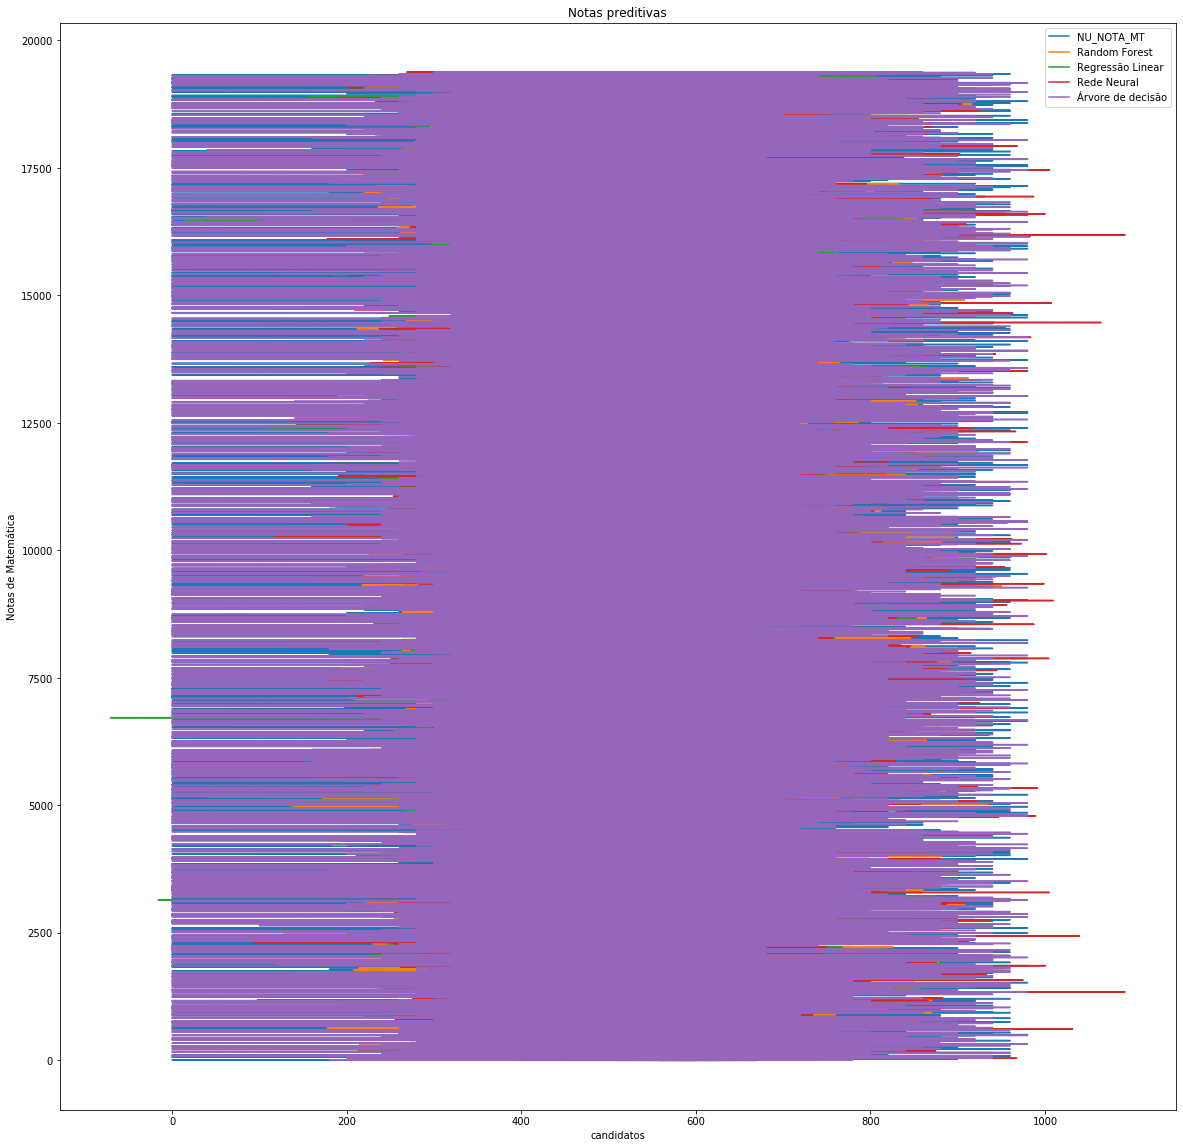

In [28]:
labels = ['NU_NOTA_MT','Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']

colunas = [ 'NU_NOTA_REDACAO', 'NU_NOTA_REDACAO_Random Forest',
       'NU_NOTA_REDACAO_Regressão Linear', 'NU_NOTA_REDACAO_Rede Neural',
       'NU_NOTA_REDACAO_Árvore de decisão']


fig, ax = plt.subplots(figsize=(20, 20))

for label, coluna in zip(labels, colunas):
    ax.plot(df_resposta[coluna],x_ticks, label = label)


plt.xlabel('candidatos')
plt.ylabel('Notas de Matemática')
plt.title("Notas preditivas")
plt.legend()
plt.show()

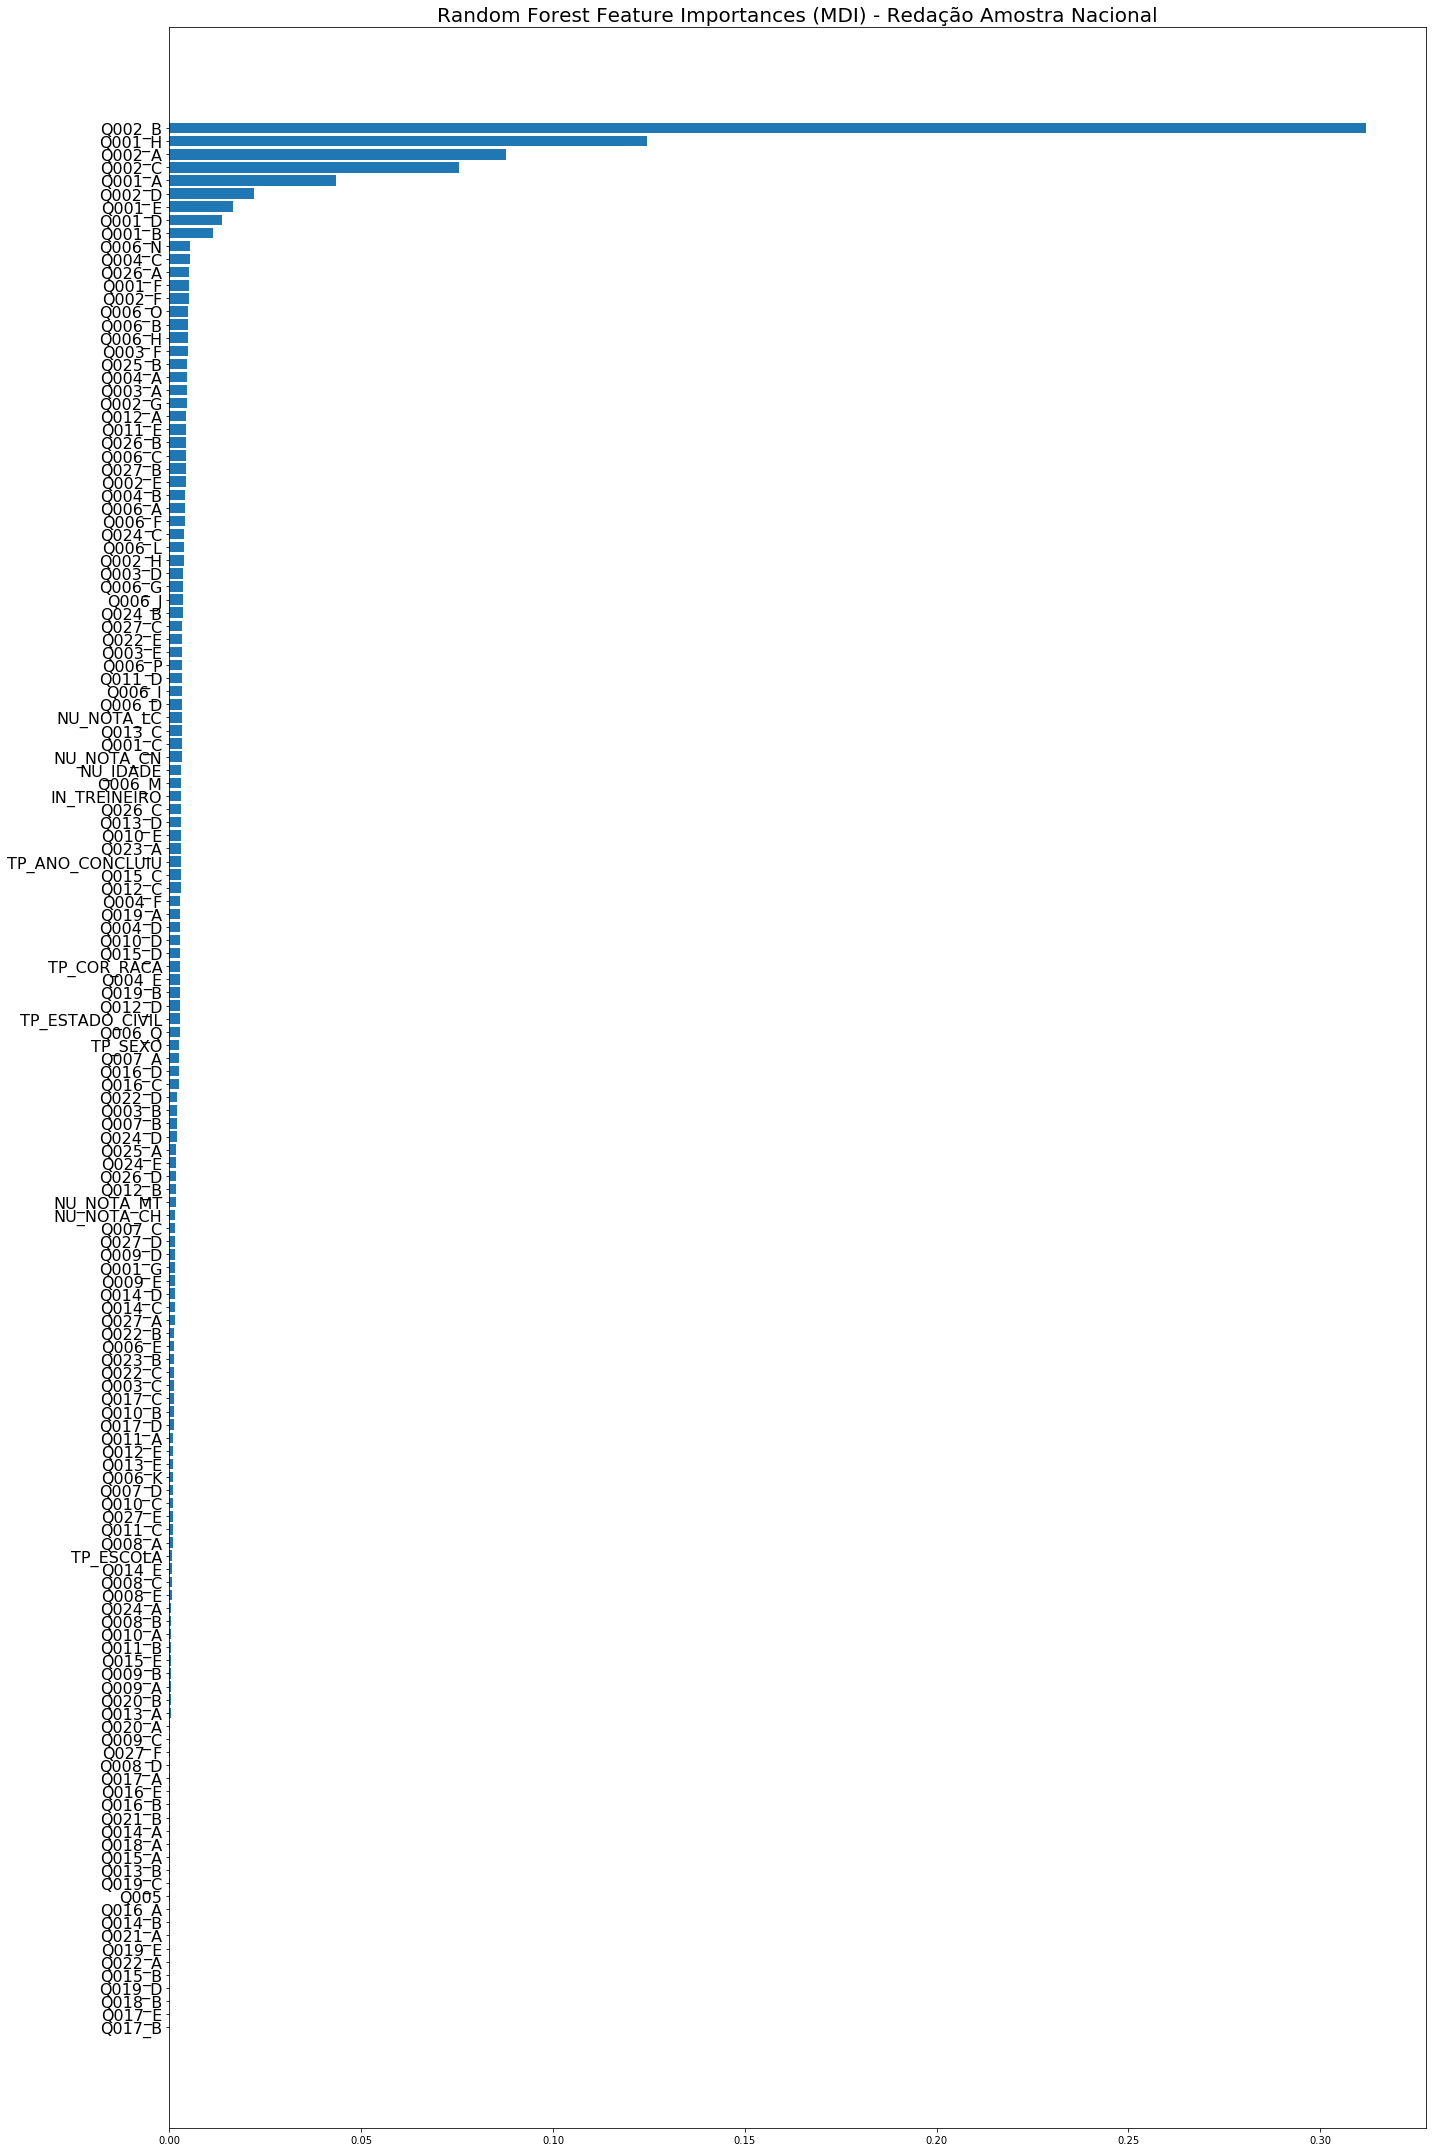

In [27]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 30))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 16)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) - Redação Amostra Nacional", fontsize = 20)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesRedacaoBR.png', format='png')
plt.show()

In [35]:
len(feature_names)
len(categorical_features)
df_resposta['NU_NOTA_MT_RF'].shape

(300,)

In [38]:
#sns.catplot(x=X_test.Q001, y=df_resposta.NU_NOTA_MT_RF);

# Plotando a distribuíção das notas

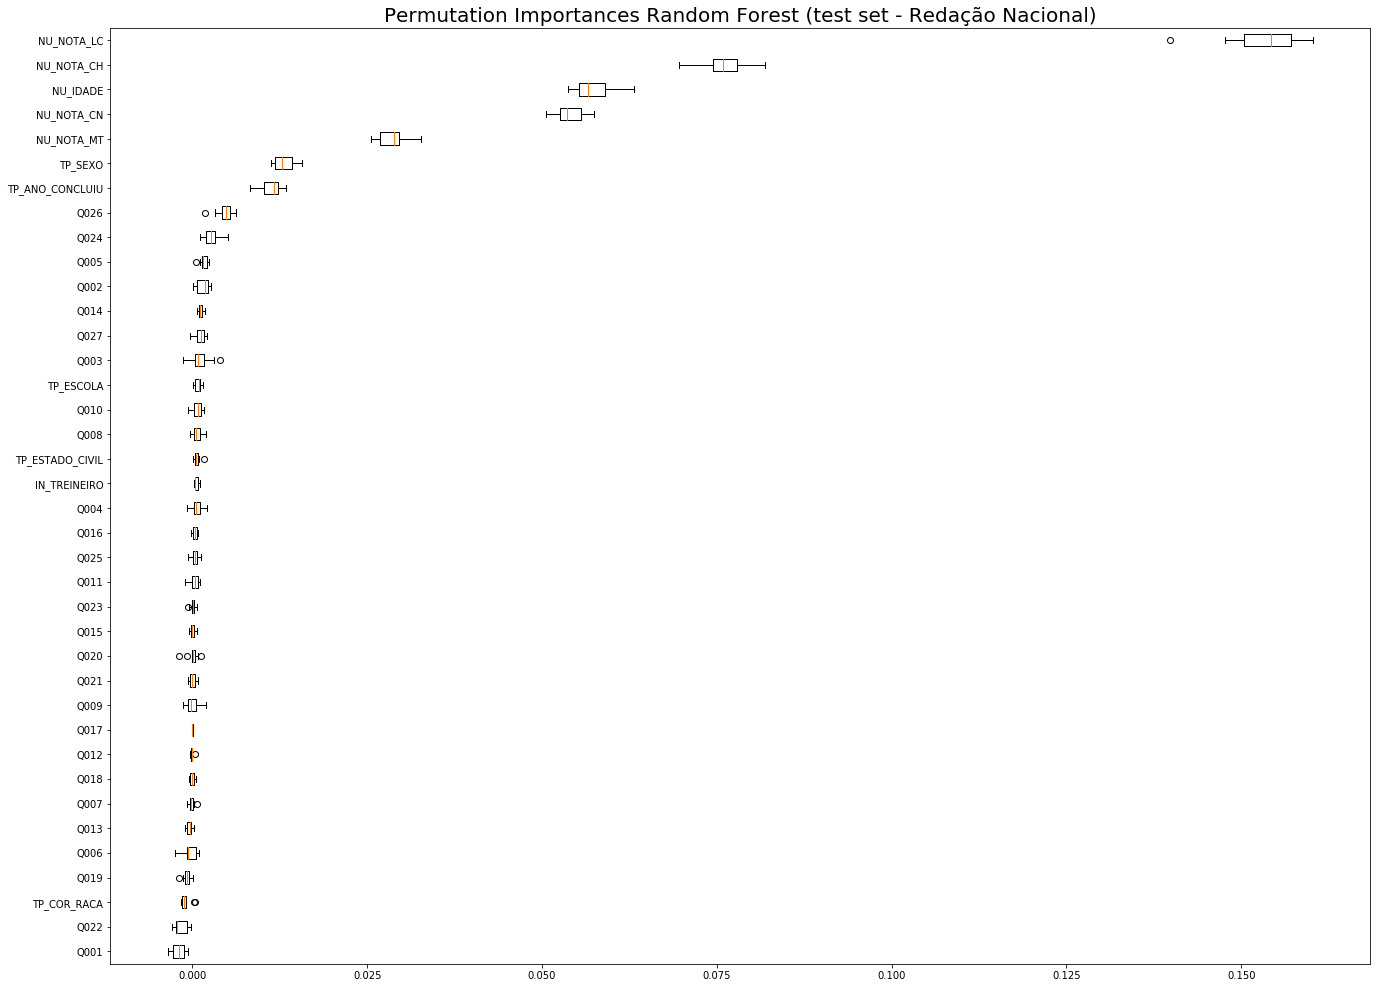

In [29]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances Random Forest (test set - Redação Nacional)", fontsize=20)
#ax.set_ylabel(fontsize = 13)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/featuresImportancesNacional.png', format='png')

plt.show()

In [39]:
df_resposta.columns

Index(['NU_INSCRICAO', 'NU_NOTA_REDACAO', 'NU_NOTA_REDACAO_Random Forest',
       'NU_NOTA_REDACAO_Regressão Linear', 'NU_NOTA_REDACAO_Rede Neural',
       'NU_NOTA_REDACAO_Árvore de decisão'],
      dtype='object')

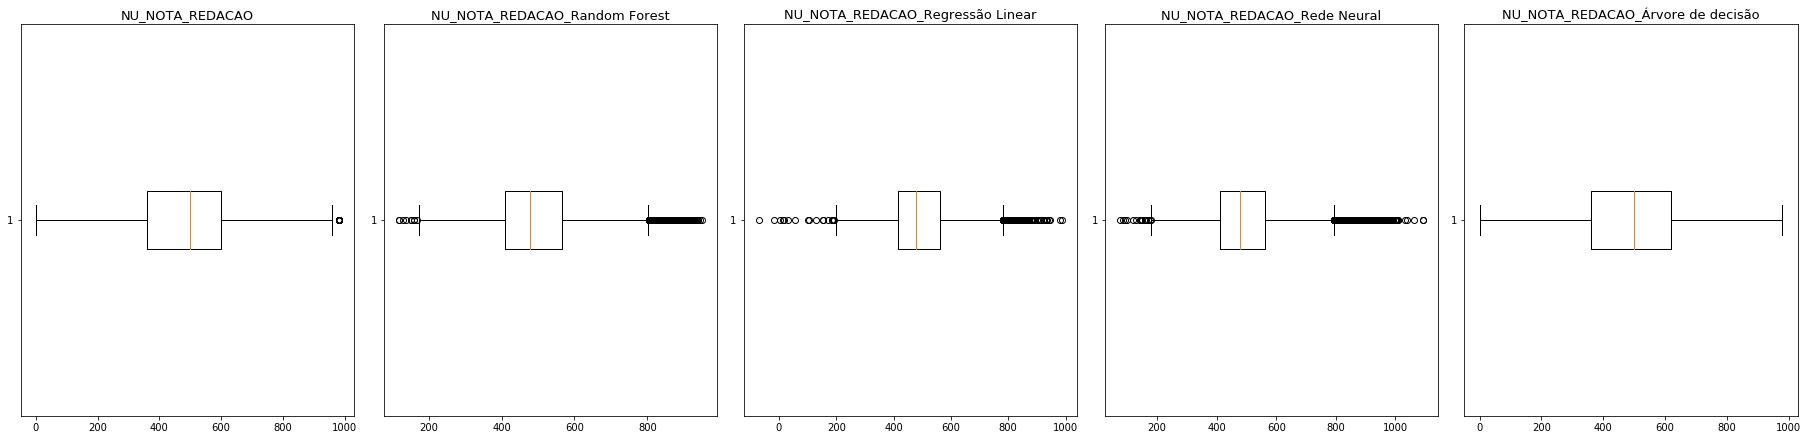

In [52]:
fig, axs = plt.subplots(1, 5, figsize=[25,6], constrained_layout=True)

idx=['NU_NOTA_REDACAO', 'NU_NOTA_REDACAO_Random Forest',
       'NU_NOTA_REDACAO_Regressão Linear', 'NU_NOTA_REDACAO_Rede Neural',
       'NU_NOTA_REDACAO_Árvore de decisão']
for ax, i in zip(axs, idx):
    ax.set_title(i, fontsize = 13)
    ax.boxplot(df_resposta[i], vert=False)

#plt.savefig('imagens/featuresImportances.png', format='png')

plt.show()


Text(0.5, 1.0, '')

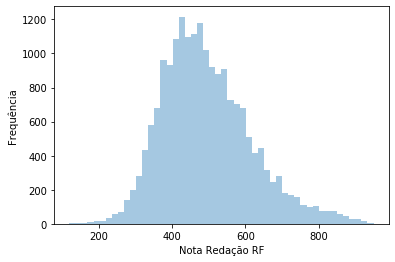

In [36]:
fig, axs = plt.subplots(1, 5, figsize=[6,4], constrained_layout=True)
ax = sns.distplot(df_resposta['NU_NOTA_REDACAO_Random Forest'], norm_hist= False, kde= False)
ax.set(xlabel='Nota Redação RF', ylabel='Frequência')
ax.set_title('')

In [56]:
y_ticks = np.arange(0,len(feature_names))
y_ticks
df_resposta['NU_NOTA_REDACAO_Random Forest'].shape
for x in categorical_features:
     v = X_train[x]
df_cat = pd.DataFrame()
df_cat = X_test[categorical_features]
#cat = pd.concat([cat, df_resposta], axis=1, join='inner')



In [2]:
letras = ['A', 'B', 'C',  'D',
                 'E',
                 'F',
                 'G',
                 'H',
                 'I',
                 'J',
                 'K',
                 'L',
                 'M',
                 'N',
                 'O',
                 'P',
                 'Q']

In [54]:


print(df_cat.groupby("Q001"))

ValueError: 'c' argument has 32 elements, which is not acceptable for use with 'x' with size 19382, 'y' with size 19382.

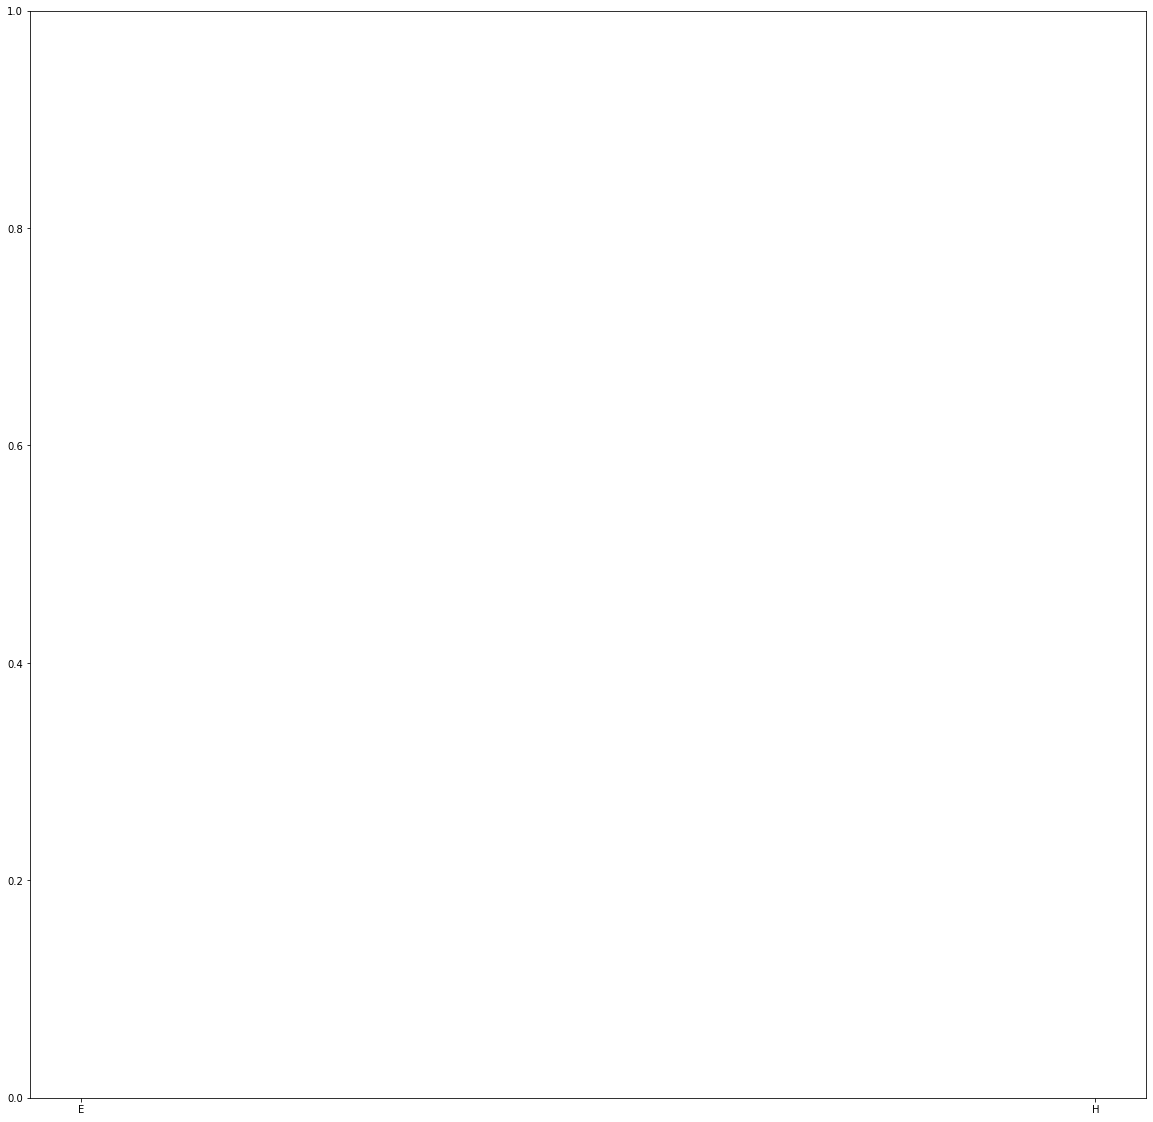

In [59]:


y_ticks = np.arange(0,len(feature_names))
c = np.random.randint(1, 20, size=32)
fig, ax = plt.subplots(figsize=(20, 20))
labels = categorical_features
for l  in  labels:  
    ax.scatter(X_test[l], df_resposta['NU_NOTA_REDACAO_Random Forest'], alpha=0.5,  c=c )
    ax.set_yticklabels(l)
    ax.set_yticks(y_ticks)
    
plt.grid(True)
plt.xlabel('features categóricas', fontsize=15)
plt.ylabel('NU_NOTA_MT_RF', fontsize=15)
plt.title('Gráfico de dispersão', fontsize=19)

plt.savefig('imagens/graficoDispersao.png', format='png')
plt.show()

In [53]:
import matplotlib as mpl
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)
fig, ax = plt.subplots(figsize=(6, 6))
#print(X_test.sort_values('Q001')['Q001'])
ax.scatter(, df_resposta['NU_NOTA_MT_Random Forest'])

SyntaxError: invalid syntax (<ipython-input-53-a02b2e794496>, line 6)

In [54]:
sns.catplot(x="Q001", y="NU_NOTA_MT_Random Forest", data=df);

NameError: name 'df' is not defined

ValueError: Could not interpret input 'NU_NOTA_MT_Random Forest'

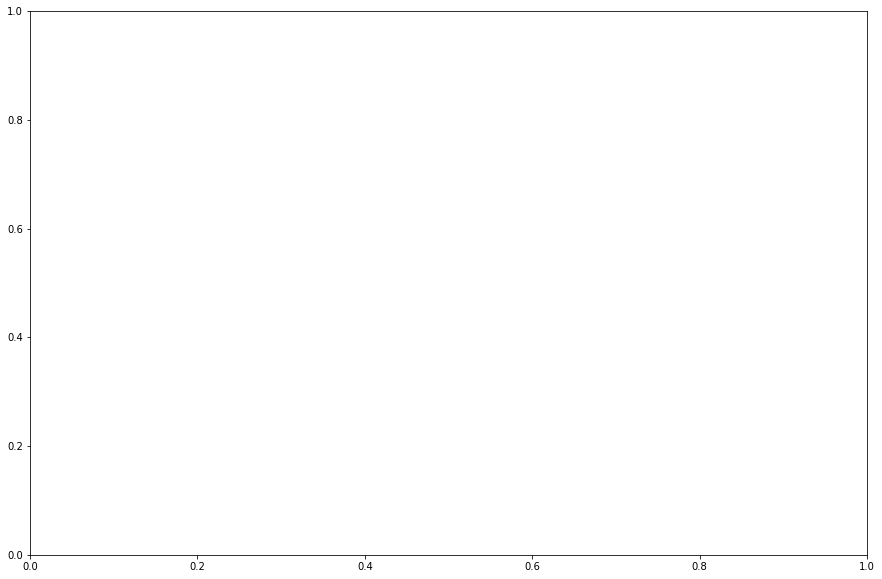

In [41]:
N = 45
x, y = np.random.rand(2, N)
c = np.random.randint(1, 8, size=N)
s = np.random.randint(10, 220, size=N)

fig, ax = plt.subplots(figsize=(15, 10))




ax = sns.catplot(x="Q001", y="NU_NOTA_MT_Random Forest", data=df_cat)
#sns.catplot( y="NU_NOTA_MT_Random Forest", data=df, color = "c")
#sns.catplot(x="Q001", y="NU_NOTA_MT_Random Forest", data=df)


#ax.add_artist(legend1)



plt.show()

KeyError: 'NU_NOTA_MT_Random Forest'

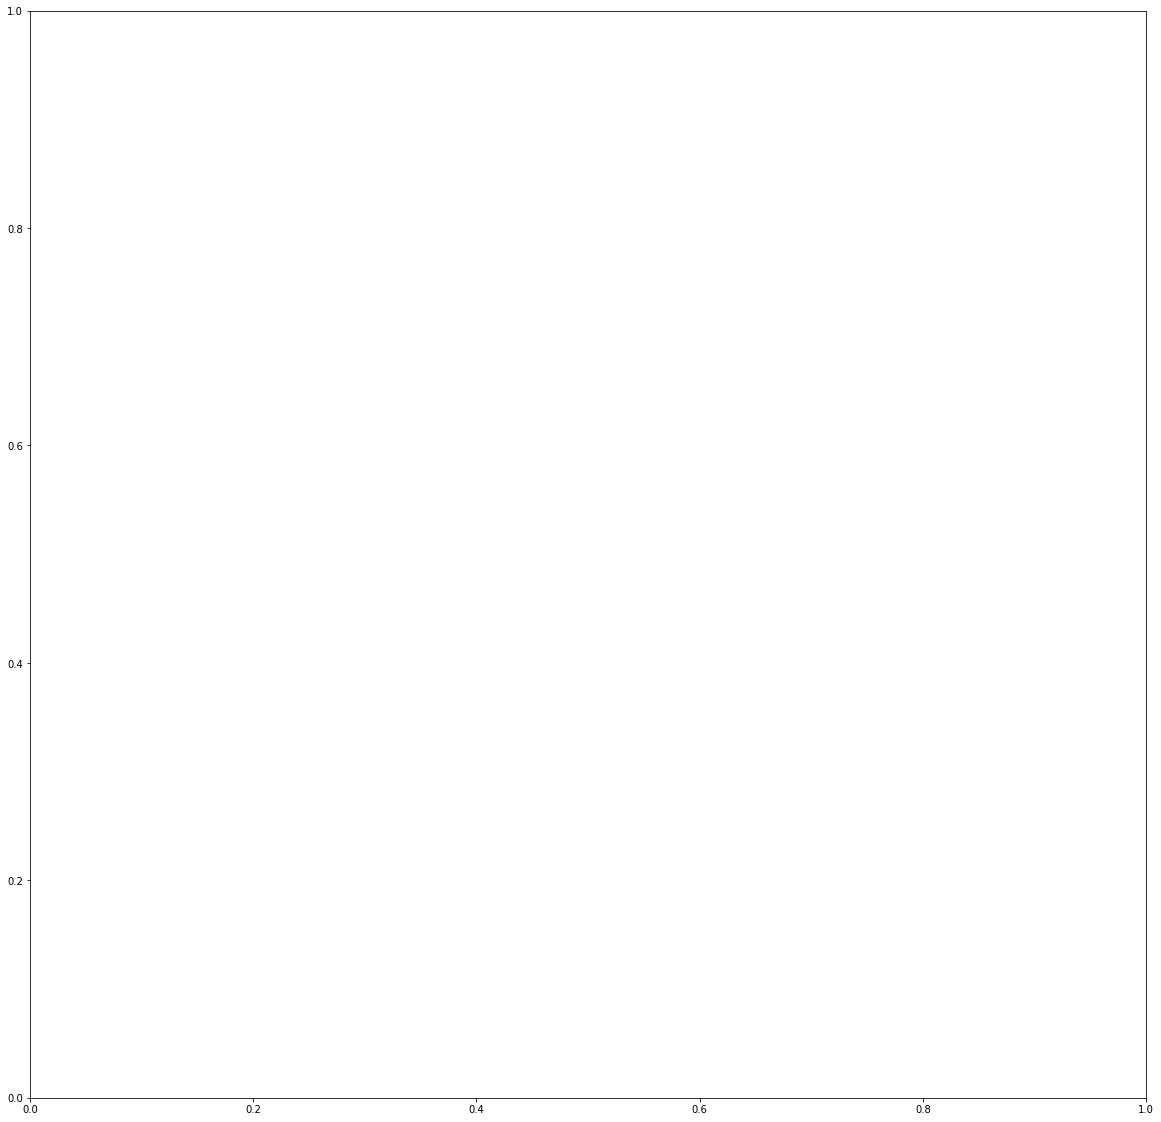

In [117]:
y_ticks = np.arange(0, len(categorical_features))
cmap = plt.cm.RdYlBu
fig, ax = plt.subplots(figsize=(20, 20))
for i in categorical_features:
    ax.scatter(X_test[i], df_resposta['NU_NOTA_REDACAO_Random Forest'], label = i, cmap = cmap)
#ax.set_yticklabels('Q001')
#ax.set_yticks(y_ticks)

plt.grid(True)
plt.xlabel('features categóricas', fontsize=15)
plt.ylabel('NU_NOTA_MT_RF', fontsize=15)
plt.title('Gráfico de dispersão', fontsize=19)
plt.legend()
plt.show()

In [ ]:
result_dt = permutation_importance(dtree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result_dt.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result_dt.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances Random Forest (test set)", fontsize=15)

fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_Dtree.png', format='png')

plt.show()

In [ ]:
sorted_idx
X_test.columns[sorted_idx]

# Salvar a figura a qualquer momento

In [ ]:
fig = plt.gcf()
plt.show()
fig.savefig('teste.png', format='png')

In [82]:
elapsed_time

0.5087084770202637

In [ ]:
df_resposta['NU_NOTA_MT_pred'] = y_pred
df_resposta

# Métricas

## Erro máximo

In [ ]:
#from sklearn.metrics import max_error
metrics.max_error(y_test, y_pred)

## Mean absolute error

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred_test)
mean_absolute_error(y_train, y_pred_train)

print(mean_absolute_error(y_test, y_pred_test),
mean_absolute_error(y_train, y_pred_train))

## Mean squared error

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

##  R² score, the coefficient of determination

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

In [34]:
#df_resposta['NU_NOTA_MT_RF'] = y_pred
#df_resposta

,NU_INSCRICAO,NU_NOTA_MT,NU_NOTA_MT_RF
993,180008416816,595.8,576.50
859,180008881225,687.7,480.00
298,180007354112,534.1,533.67
553,180008393057,542.7,522.52
672,180009238835,486.6,654.11
...,...,...,...
167,180007805560,493.2,479.30
998,180008414250,456.6,597.13
984,180008405181,485.5,514.29
491,180008379536,469.8,477.24
